# Map preprocessing

In [1]:
import networkx as nx
import osmnx as ox

In [2]:
#Load map
g=ox.graph_from_place('Paris, France', network_type='bike',simplify=False)
gdf_nodes, gdf_edges=ox.graph_to_gdfs(g)

#Prune road types
remove_tags=['bridleway','path','unclassified','road']

del_list=[]
for j,i in gdf_edges.iterrows():
    if i["highway"] in remove_tags:
        del_list.append(j)
gdf_edges=gdf_edges.drop(index=del_list)
g=ox.utils_graph.graph_from_gdfs(gdf_nodes, gdf_edges, graph_attrs=None)  

#Rebuild the map
largest_cc = max(nx.strongly_connected_components(g), key=len)
g = g.subgraph(largest_cc)
gdf_nodes, gdf_edges=ox.graph_to_gdfs(g)
gdf_edges=gdf_edges.droplevel(-1)

# Data generation

In [3]:
from DataGenerator import DataGenerator2 as DataGenerator
import csv
import ast

from sklearn.model_selection import train_test_split

In [4]:
def save_data(samplings,tracks,append=False):
    mode = "a" if append else "w"

    with open("data/generated-data-samplings.csv", mode) as f:  
        writer = csv.writer(f, delimiter=';', quoting=csv.QUOTE_MINIMAL, lineterminator='\n')
        for sampling in samplings:
            writer.writerow(sampling)

    with open("data/generated-data-tracks.csv", mode) as f:  
        writer = csv.writer(f, delimiter=';', quoting=csv.QUOTE_MINIMAL, lineterminator='\n')
        for track in tracks:
            writer.writerow(track)

def load_data():
    with open('data/generated-data-samplings.csv', 'r') as f:
        samplings=[]
        for sampling in f:
            entries = sampling.strip().split(';')
            nested_lists = [ast.literal_eval(entry) for entry in entries]
            samplings.append(nested_lists)

    with open('data/generated-data-tracks.csv', 'r') as f:
        tracks=[]
        for track in f:
            entries = track.strip().split(';')
            nested_lists = [ast.literal_eval(entry) for entry in entries]
            tracks.append(nested_lists)
    return samplings, tracks

In [5]:
#Create the generator
path="data/comptage-velo-donnees-compteurs.csv"
datagen=DataGenerator(G=g,gdf_nodes_edges=(gdf_nodes,gdf_edges),data_path=path)

Loading data...
Linking stations to nodes...
Generating node masks...


*Note: This code is commented out so the data is not regenerated and added to the generated-data files again. Uncommentint it results in the 

In [6]:
# #Generate data in bacthes and save it to the generated data
# generator_batch_size=100
# n_batches=10
# for batch in range(n_batches):
#     samplings,tracks=datagen.track_generator(generator_batch_size,sampling_rate=1)
#     save_data(samplings,tracks,append=True)
#     print(f'-> {(batch+1)*generator_batch_size} trajectories generated [{100*(batch+1)/n_batches}%]')

-> 100 trajectories generated [10.0%]
-> 200 trajectories generated [20.0%]
-> 300 trajectories generated [30.0%]
-> 400 trajectories generated [40.0%]
-> 500 trajectories generated [50.0%]
-> 600 trajectories generated [60.0%]
-> 700 trajectories generated [70.0%]
-> 800 trajectories generated [80.0%]
-> 900 trajectories generated [90.0%]
-> 1000 trajectories generated [100.0%]


(<Figure size 1600x1200 with 1 Axes>,
 <Axes: title={'center': 'Heatmap of trajectories'}>)

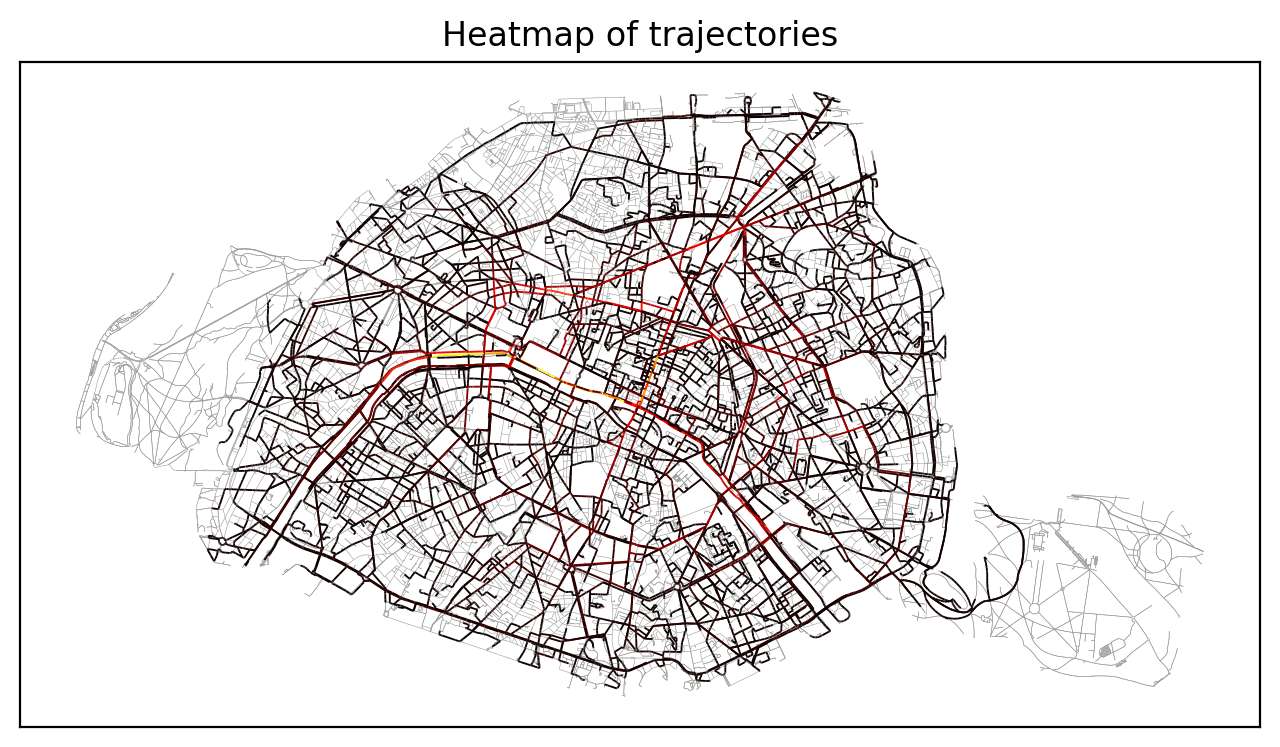

In [7]:
#Load the generated data
phi,T=load_data()
datagen.plot_heatmap(phi,
                     show_non_traversed=True,show_stations=False,
                     show_start=False,show_end=False,
                     legend=False,cmap='hot',bkg_color='w',dpi=200)

In [8]:
phi_train,phi_test,T_train,T_test=train_test_split(phi,T,train_size=0.8,random_state=2023)

def downsampling(phi,samping_rate):
    return [phi_i[::samping_rate] for phi_i in phi]

sampling_rates=[60,2*60,5*60,10*60]
# phi_test_dict={1:phi_test}
phi_test_dict={}
for sr in sampling_rates:
    phi_test_dict[sr]=downsampling(phi_test,sr)

# Travel time distribution

In [9]:
import numpy as np
from collections import Counter
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

## Baseline travel time distribution

In [10]:
baseline_TTD = ox.add_edge_speeds(g)
baseline_TTD = ox.add_edge_travel_times(baseline_TTD)

## Our time distribution

In [11]:
# Since the timestamp represents second, we add a counter to count the travel time between each node connection
track_with_counter = []
for sub_list1, sub_list2 in zip(phi_train, T_train):
    pair_counts = Counter(tuple(row[1:3]) for row in sub_list1)
    updated_list = [(pair[0], pair[1], pair_counts.get(pair, 0)) for pair in sub_list2]
    track_with_counter.append(updated_list)

In [12]:
# Flatten the list first for easier processing
flattened_list = [item for sublist in track_with_counter for item in sublist]

# Make a Dictionary to store accumulated travel_time and count for each node pair
node_travel_time = defaultdict(lambda: {'total_travel_time': 0, 'count': 0})

# Iterate through the flattened list
for node1, node2, travel_time in flattened_list:
    # Update accumulated travel_time and count for each node pair
    node_travel_time[(node1, node2)]['total_travel_time'] += travel_time
    node_travel_time[(node1, node2)]['count'] += 1

# Calculate average travel_time for each node pair
average_travel_time = [
    ((node1, node2), data['total_travel_time'] / data['count']) 
    for (node1, node2), data in node_travel_time.items()
]

In [13]:
TTD_gdf_edges = ox.graph_to_gdfs(g, nodes=False)

average_travel_time_dict = dict(average_travel_time)

# Update the travel time column in with the trajectory data
TTD_gdf_edges['travel_time']=np.nan
for index, row in TTD_gdf_edges.iterrows():
    node_pair = (index[0], index[1])
    TTD_gdf_edges.at[index, 'travel_time'] = average_travel_time_dict.get(node_pair, row['travel_time'])

# Get average travel speed and extrapolate to unkown edges
sub=TTD_gdf_edges['travel_time']!=0
TTD_gdf_edges.loc[sub,'travel_speed']=TTD_gdf_edges.loc[sub,'length']/TTD_gdf_edges.loc[sub,'travel_time']
average_speed=TTD_gdf_edges['travel_speed'].mean(skipna=True)

sub=TTD_gdf_edges["travel_time"].isna()
TTD_gdf_edges.loc[sub,"travel_time"]=TTD_gdf_edges.loc[sub,'length']/(2/3*average_speed)

In [14]:
our_TTD=ox.graph_from_gdfs(gdf_nodes,TTD_gdf_edges)

Mean Travel Time: 5.138569925799584
Standard Deviation of Travel Time: 7.1154860911876465


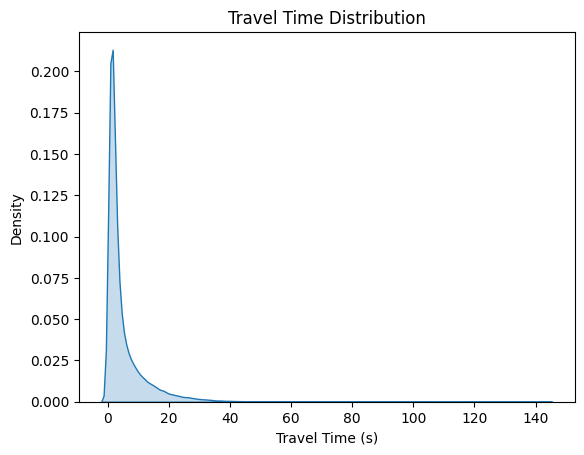

In [15]:
# Generate travel time distribution
time = TTD_gdf_edges['travel_time']
mean_travel_time = np.mean(time)
std_dev_travel_time = np.std(time)

print("Mean Travel Time:", mean_travel_time)
print("Standard Deviation of Travel Time:", std_dev_travel_time)

sns.kdeplot(time, fill=True)
plt.title('Travel Time Distribution')
plt.xlabel('Travel Time (s)')
plt.ylabel('Density')
plt.show()

# Trajectory recovery

In [16]:
from collections import OrderedDict

In [17]:
def edges_to_nodes(track):
    return [edge[0] for edge in track]

def nodes_to_edges(track):
    return [(track[i],track[i+1]) for i in range(len(track)-1)]

In [18]:
def recover_route(track_sampling,recovery_algorithm,debug=False):

    edges= [(n1,n2) for t,n1,n2,e in track_sampling]
    unique_edges = list(OrderedDict.fromkeys(edges))

    edge_0=unique_edges[0]
    recovered_track=[edge_0]
    n_added_edges=0
    for edge_1 in unique_edges[1:]:
        if edge_1[0]!=edge_0[1]:
            recovered_path=recovery_algorithm(edge_0[1],edge_1[0])
            recovered_track+=recovered_path
            if debug:
                # print(f'Adding {len(recovered_path)} edges between {edge_0[1]} and {edge_1[0]}')
                n_added_edges+=len(recovered_path)
                
        recovered_track.append(edge_1)
        edge_0=edge_1

    if debug:
        print(f'Recovered track consists on {len(recovered_track)} edges, of which {n_added_edges} ({100*n_added_edges/len(recovered_track):.0f}%) were added.')

    return recovered_track

In [ ]:
def recover_route_2(track_sampling,recovery_algorithm,debug=False):


    unique_edges = OrderedDict()
    for t,n1,n2,e in track_sampling:
        item_tuple = (n1,n2)
        if item_tuple not in unique_edges:
            unique_edges[item_tuple] = [t,t]
        else:
            unique_edges[item_tuple][1]=t

    edge_0,t_0=unique_edges.popitem()
    recovered_track=[edge_0]
    n_added_edges=0
    for edge_1,t_1 in unique_edges.items():
        if edge_1[0]!=edge_0[1]:
            T=t_1[0]-t_0[1]
            recovered_path=recovery_algorithm(edge_0[1],edge_1[0],T)
            recovered_track+=recovered_path
            if debug:
                # print(f'Adding {len(recovered_path)} edges between {edge_0[1]} and {edge_1[0]}')
                n_added_edges+=len(recovered_path)
                
        recovered_track.append(edge_1)
        edge_0=edge_1

    if debug:
        print(f'Recovered track consists on {len(recovered_track)} edges, of which {n_added_edges} ({100*n_added_edges/len(recovered_track):.0f}%) were added.')

    return recovered_track

In [19]:
def recover_routes_from_samplings(samplings,recovery_algorithm,debug=False):
    return [recover_route(s,recovery_algorithm,debug=debug) for s in samplings]

## Algorithms

In [ ]:
def minimize_absolute_error_path(graph,start_node,end_node,measured_weight,weight=None):
    d1=nx.shortest_path_length(graph,source=start_node,weight=weight)
    d2=nx.shortest_path_length(graph,target=end_node,weight=weight)
    middle_node,err=min({key: np.abs(d1[key]+ d2[key]-measured_weight) for key in d1.keys()}.items(), key=lambda x:x[1])
    p1=nx.shortest_path(graph,source=start_node,target=middle_node,weight=weight)
    p2=nx.shortest_path(graph,source=middle_node,target=end_node,weight=weight)
    return p1+p2[1:],err

In [20]:
def baseline_recovery_algorithm(n1,n2):
    recovered_path=nx.shortest_path(g, n1, n2, weight='length')
    return nodes_to_edges(recovered_path)

In [21]:
# def baseline_TTD_recovery_algorithm(n1,n2):
#     recovered_path=nx.shortest_path(baseline_TTD, n1, n2, weight='travel_time')
#     return nodes_to_edges(recovered_path)

def baseline_TTD_recovery_algorithm(n1,n2):
    recovered_path=nx.shortest_path(baseline_TTD, n1, n2, weight='travel_time')
    return nodes_to_edges(recovered_path)

In [22]:
# def our_TTD_recovery_algorithm(n1,n2):
#     recovered_path=nx.shortest_path(our_TTD, n1, n2, weight='travel_time')
#     return nodes_to_edges(recovered_path)

def our_TTD_recovery_algorithm(n1,n2):
    recovered_path=nx.shortest_path(our_TTD, n1, n2, weight='travel_time')
    return nodes_to_edges(recovered_path)

In [ ]:
def our_TTD_recovery_algorithm2(n1,n2,T):
    recovered_path=nx.minimize_absolute_error_path(our_TTD, n1, n2, T, weight='travel_time')
    return nodes_to_edges(recovered_path)

## Recovery

In [23]:
results={k:{} for k in ['baseline','baseline-TTD','our-TTD']}
for sr,phi_sr in phi_test_dict.items():
    T_hat_baseline=recover_routes_from_samplings(phi_sr,baseline_recovery_algorithm)
    results['baseline'][sr]=T_hat_baseline

    T_hat_baseline_TTD=recover_routes_from_samplings(phi_sr,baseline_TTD_recovery_algorithm)
    results['baseline-TTD'][sr]=T_hat_baseline_TTD

    T_hat_our_TTD=recover_routes_from_samplings(phi_sr,our_TTD_recovery_algorithm)
    results['our-TTD'][sr]=T_hat_our_TTD

## Recovery evaluation

In [24]:
def accuracy(T,T_hat):
    def relative_intersection(track_i,track_j):
        """
        Returns what portion of the edges from track_i are present in track_j
        """

        #Convert list of edges into set of edges
        set_i=set(track_i)
        set_j=set(track_j)

        #Calculate intesection
        intersect=set_i.intersection(set_j)
        n=len(intersect)
        
        return n/max(len(set_i),len(set_j))
    
    error=0
    for track_i,track_j in zip(T,T_hat):
        error+=relative_intersection(track_i,track_j)
    return error/len(T)

In [25]:
for model,results_i in results.items():
    print(f'\n------------------\n    {model}\t\n------------------')   
    for sr,T_hat in results_i.items():
        print(f"Sampling rate {sr}s/{sr/60:.0f}min -> ",end='')
        a=accuracy(T_test,T_hat)
        print(f"Accuracy: {a:.4f}")


------------------
    baseline	
------------------
Sampling rate 60s/1min -> Accuracy: 0.8908
Sampling rate 120s/2min -> Accuracy: 0.7798
Sampling rate 300s/5min -> Accuracy: 0.5644
Sampling rate 600s/10min -> Accuracy: 0.3136

------------------
    baseline-TTD	
------------------
Sampling rate 60s/1min -> Accuracy: 0.8873
Sampling rate 120s/2min -> Accuracy: 0.7745
Sampling rate 300s/5min -> Accuracy: 0.5332
Sampling rate 600s/10min -> Accuracy: 0.2969

------------------
    our-TTD	
------------------
Sampling rate 60s/1min -> Accuracy: 0.9222
Sampling rate 120s/2min -> Accuracy: 0.8546
Sampling rate 300s/5min -> Accuracy: 0.6874
Sampling rate 600s/10min -> Accuracy: 0.4283


# Clustering

In [26]:
import pandas as pd
import numpy as np
import geopandas as gp
import matplotlib.pyplot as plt

from sklearn_extra.cluster import KMedoids

In [27]:
def row_wise_track_similarity(G,T):
    M=np.zeros((len(T),len(T)))
    G_aux=G.copy()

    for i,track_i in enumerate(T):

        G_aux.add_node("vSource")
        G_aux.add_edges_from(("vSource", n, {'length': 0}) for n in track_i)
        dists=nx.shortest_path_length(G_aux,source="vSource",weight="length")
        G_aux.remove_node("vSource")

        for j,track_j in enumerate(T):
            if i==j:
                continue
            
            max_dist=max(dists[m] for m in track_j)
                    
            M[i,j]=max_dist
    return M

In [28]:
def symmetrize(M,strategy='min'):
    if strategy=='mean':
        return (1/2)*(M+M.T)
    if strategy=='min':
        return np.minimum(M,M.T)
    if strategy=='max':
        return np.maximum(M,M.T)
    raise KeyError(f'{strategy} is not a valid strategy')

In [29]:
def k_corridors_medoid_summarizer(M,k,T,**kwargs):
    kmedoids = KMedoids(n_clusters=k, metric='precomputed', **kwargs) #For example random_state=0
    kmedoids.fit(M)

    cluster_labels = kmedoids.labels_
    medoid_indices = kmedoids.medoid_indices_
    d=kmedoids.inertia_

    k_corridors=[T[i] for i in medoid_indices]
    return k_corridors,medoid_indices,cluster_labels

In [30]:
M_dict={k:{} for k in results.keys()}
paths_dict={k:{} for k in results.keys()}
for model in M_dict.keys():
    for sr,T_hat in results[model].items():
        paths_hat=[edges_to_nodes(track) for track in T_hat]
        M=row_wise_track_similarity(g,paths_hat)
        M=symmetrize(M,strategy='max')
        M_dict[model][sr]=M
        paths_dict[model][sr]=paths_hat

In [31]:
n_clusters=8

clustering_dict={k:{} for k in results.keys()}
for model,sub_dict in M_dict.items():
    for sr,M in sub_dict.items():
        T=paths_dict[model][sr]
        clustering=k_corridors_medoid_summarizer(M,n_clusters,T,random_state=42)
        clustering_dict[model][sr]=clustering #k_corridors,k_index,cluster_labels

# Evaluation

## k-metrics
For k-metrics, we compare an evaluation parameter with _all_ k corridors at once. I.e., for a track we don't evaluate if there is an intersection with a corridor but with _all_ of them

In [32]:
def k_absolute_intersect(track_i,k_tracks):
    """
    Returns 1 if there is at least one edge from track_i present in k_tracks,
    and 0 otherwise
    """

    #Convert list of nodes into list of edges
    set_i=set(nodes_to_edges(track_i))

    for track_j in k_tracks:
        set_j=set(nodes_to_edges(track_j))

        #Calculate intesection
        intersect=set_i.intersection(set_j)
        n=len(intersect)
        if n!=1:
            return 1
    
    return 0
    

In [33]:
def k_relative_intersect(track_i,k_tracks):
    """
    Returns what portion of the edges from track_i are present in k_tracks
    """

    #Convert list of nodes into list of edges
    set_i=set(nodes_to_edges(track_i))
    k_edges=np.concatenate([nodes_to_edges(track_j) for track_j in k_tracks])
    set_j=set([(n1,n2) for n1,n2 in k_edges])

    #Calculate intesection
    intersect=set_i.intersection(set_j)
    n=len(intersect)
    
    return n/len(set_i)

In [34]:
def k_lenght_relative_intersect(track_i,k_tracks,G):
    """
    Returns what portion of the length of track_i is in the cummulative length of the edges
    also present in k_tracks
    """

    #Convert list of nodes into list of edges
    set_i=set(nodes_to_edges(track_i))
    k_edges=np.concatenate([nodes_to_edges(track_j) for track_j in k_tracks])
    set_j=set([(n1,n2) for n1,n2 in k_edges])

    #Calculate intersection
    intersect=set_i.intersection(set_j)

    l_intersect=sum([G.get_edge_data(*edge)[0]['length'] for edge in intersect])
    l_i=sum([G.get_edge_data(*edge)[0]['length'] for edge in set_i])


    
    return l_intersect/l_i

In [35]:
def evaluate_k_metric(metric_fun,T,k_corridors,**kwargs):
    """
    Returs the cummulative value (normalized by the number of tracks) of the 
    selected metric for the selected k corridors.
    T: A list of tracks to be evaluated (if k_corridors are included they will also be evaluated)
    k_corridors: A list of k selected corridors
    metric_fun: The metric function to evaluate as metric_fun(T[i],k_corridors[j],**kwargs)
    """

    result=0
    for track_i in T:
        result+=metric_fun(track_i,k_corridors,**kwargs)

    result/=len(T)

    return result

## M-metrics
M-metrics apply a matrix operation to the set of tracks and clusters

In [36]:
def evaluate_M(G,T,cluster_labels,k_index,sym_strategy=None):
        M=row_wise_track_similarity(G,T)
        if sym_strategy:
            M=symmetrize(M,strategy=sym_strategy)

        d=np.min(M[:,k_index],axis=1).sum()
        return d

In [37]:
def M_similarity(G,T,cluster_labels,k_index,include_corridors=False,ponderated=True,ponderation_k=1):
    '''
    This metric returns a metric based on the average similarity distance from
    the tracks to the corridors.
    If include_corridors, the average is made taking into consideration the corridors
    as tracks too, otherwise the average is made using only the rest of the tracks.
    
    If ponderated, the result is ponderated so that the metric ranges (0,1],
    where 1 means all tracks are corridors and 0 tracks are at an infinite distance from the corridors.
    The ponderation is k/(k+d), where k is the ponderation parameter that defines at which d
    the ponderated score is equal to 1/2
    '''

    d=evaluate_M(G,T,cluster_labels,k_index)
    n=len(T)
    if not include_corridors:
        n-=len(k_index)
    d/=n
    if ponderated:
        return ponderation_k/(ponderation_k+d)
    return d

## Evaluate

In [38]:
T=[edges_to_nodes(track) for track in T_test]

for model,sub_dict in clustering_dict.items():
    print(f'\n\n------------------\n    {model}\t\n------------------')   
    for sr,clustering in sub_dict.items():
        k_corridors,k_index,cluster_labels=clustering
        k_corridors=[k_c for k_c in k_corridors if len(k_c)>1]

        print(f"\nSampling rate {sr}s/{sr/60:.0f}min\n------------")

        print("\nk-set metrics:")

        abs_inter=evaluate_k_metric(k_absolute_intersect,T,k_corridors)
        print("Absolute intersection: {:.4f}".format(abs_inter))

        rel_inter=evaluate_k_metric(k_relative_intersect,T,k_corridors)
        print("Relative intersection: {:.4f}".format(rel_inter))

        l_rel_inter=evaluate_k_metric(k_lenght_relative_intersect,T,k_corridors,G=g)
        print("Length intersection: {:.4f}".format(l_rel_inter))

        print("\nM metrics:")

        m_d=M_similarity(g,T,cluster_labels,k_index,ponderated=False,include_corridors=True)
        print("M average distance: {:.0f}m".format(m_d))

        ponderation_k=1000
        # m_sim=M_similarity(g,T,cluster_labels,k_index,ponderated=True,ponderation_k=ponderation_k,include_corridors=True)
        m_sim=ponderation_k/(ponderation_k+m_d)
        print("Ponderated M similarity (k={}): {:.4f}".format(ponderation_k,m_sim))



------------------
    baseline	
------------------

Sampling rate 60s/1min
------------

k-set metrics:
Absolute intersection: 1.0000
Relative intersection: 0.1389
Length intersection: 0.1513

M metrics:
M average distance: 2048m
Ponderated M similarity (k=1000): 0.3281

Sampling rate 120s/2min
------------

k-set metrics:
Absolute intersection: 1.0000
Relative intersection: 0.1394
Length intersection: 0.1526

M metrics:
M average distance: 2042m
Ponderated M similarity (k=1000): 0.3288

Sampling rate 300s/5min
------------

k-set metrics:
Absolute intersection: 1.0000
Relative intersection: 0.0981
Length intersection: 0.1080

M metrics:
M average distance: 1945m
Ponderated M similarity (k=1000): 0.3396

Sampling rate 600s/10min
------------

k-set metrics:
Absolute intersection: 1.0000
Relative intersection: 0.0598
Length intersection: 0.0567

M metrics:
M average distance: 2048m
Ponderated M similarity (k=1000): 0.3281


------------------
    baseline-TTD	
------------------

Sam

# Trash

In [39]:
import networkx as nx
import numpy as np

def minimize_absolute_error_path(graph, start_node, end_node, measured_weight, cutoff_scale=2,weight="weight"):
   
    # Generate all possible paths from start_node to end_node
    all_paths = nx.all_simple_paths(graph, start_node, end_node, cutoff=cutoff_scale*measured_weight)

    # Calculate the absolute error for each path
    absolute_errors = []
    paths=[]
    print(len(list(all_paths)))
    for num,path in enumerate(all_paths):
        print(num)
        path_length = sum(graph[path[i]][path[i+1]][weight] for i in range(len(path)-1))
        absolute_errors.append( abs(path_length - measured_weight))
        paths.append(path)
    
    # Find the path with the minimum absolute error
    min_index=np.argmin(absolute_errors)
    min_error_path=paths[min_index]
    
    return min_error_path,paths,absolute_errors

In [40]:
def minimize_absolute_error_path_v3(graph,start_node,end_node,measured_weight,weight=None):
    d1=nx.shortest_path_length(graph,source=start_node,weight=weight)
    d2=nx.shortest_path_length(graph,target=end_node,weight=weight)
    middle_node,err=min({key: np.abs(d1[key]+ d2[key]-measured_weight) for key in d1.keys()}.items(), key=lambda x:x[1])
    p1=nx.shortest_path(graph,source=start_node,target=middle_node,weight=weight)
    p2=nx.shortest_path(graph,source=middle_node,target=end_node,weight=weight)
    return p1+p2[1:],err

In [41]:
def minimize_absolute_error_path_v2(graph, start_node, end_node, measured_weight,weight="weight"):
    # Use Dijkstra's algorithm to find the shortest path in terms of weights
    shortest_path = nx.shortest_path(graph, source=start_node, target=end_node, weight=weight)

    # Function to calculate the absolute error for a given path
    def calculate_absolute_error(path):
        path_length = sum(graph[path[i]][path[i+1]][0][weight] for i in range(len(path)-1))
        return abs(path_length - measured_weight)

    # Initialize minimum absolute error and path
    min_absolute_error = calculate_absolute_error(shortest_path)
    print('Inital error:',min_absolute_error)
    min_error_path = shortest_path

    # Iterate over neighbors of nodes in the shortest path to find the minimum error path
    for i in range(len(shortest_path) - 1):
        current_node = shortest_path[i]
        next_node = shortest_path[i+1]

        # Get neighbors excluding the next node in the shortest path
        neighbors = set(graph.neighbors(current_node)) - {next_node}

        # Iterate over neighbors to find alternative paths
        for neighbor in neighbors:
            sub_path=nx.shortest_path(graph,neighbor, shortest_path[i+1],weight=weight)
            alternative_path = shortest_path[:i+1] + sub_path[:-1] + shortest_path[i+1:]
            error = calculate_absolute_error(alternative_path)

            if error < min_absolute_error:
                min_absolute_error = error
                min_error_path = alternative_path
    print('Final error:',min_absolute_error)
    return min_error_path,min_absolute_error

Inital error: 136.39999999999995
Final error: 34.30000000000001


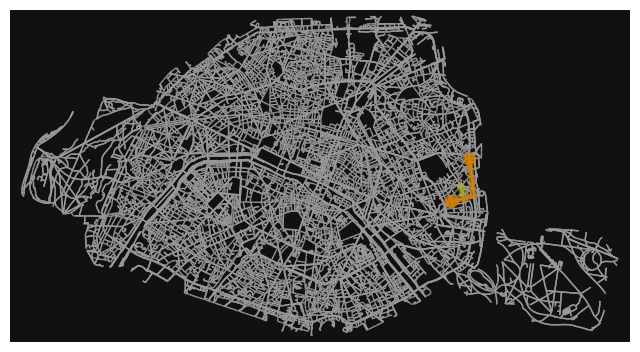

In [42]:
n1=list(g)[0]
n2=list(g)[10]
route1=nx.shortest_path(baseline_TTD,n1,n2,weight="travel_time")
route2,t=minimize_absolute_error_path_v2(baseline_TTD,n1,n2,300,weight="travel_time")
fig, ax = ox.plot_graph_routes(
    g, routes=[route1, route2], route_colors=["r", "y"], route_linewidth=6, node_size=0
)

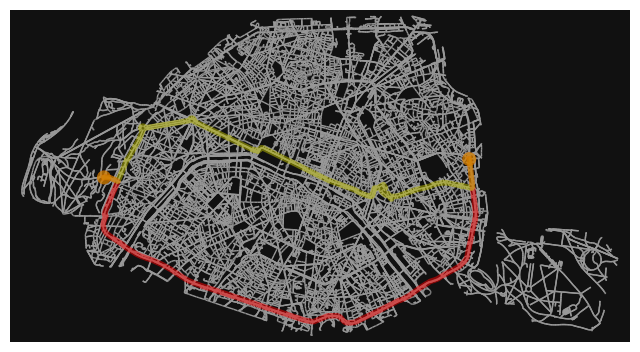

In [43]:
n1=list(g)[0]
n2=list(g)[120]
route1=nx.shortest_path(baseline_TTD,n1,n2,weight="travel_time")
route2,t=minimize_absolute_error_path_v3(baseline_TTD,n1,n2,1500,weight="travel_time")
fig, ax = ox.plot_graph_routes(
    g, routes=[route1, route2], route_colors=["r", "y"], route_linewidth=6, node_size=0
)

(<Figure size 1600x1200 with 1 Axes>,
 <Axes: title={'center': 'Heatmap of trajectories'}>)

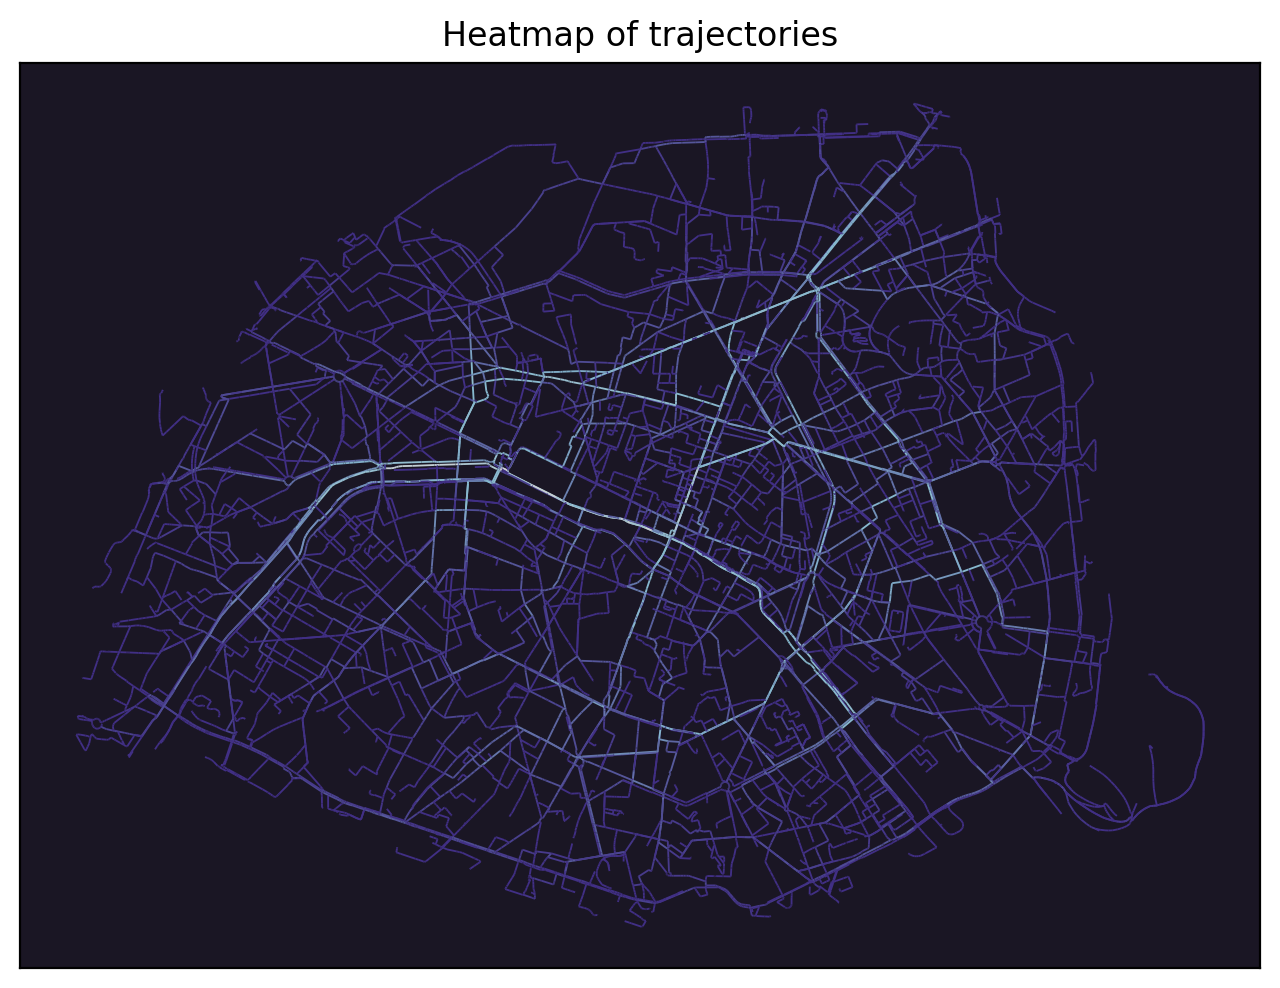

In [44]:
from matplotlib.colors import LinearSegmentedColormap
colors=["#412F85", "#86B8CE","#9FC1D0","#C1CDD3","#D2D4D5"]
cmap=LinearSegmentedColormap.from_list('', colors, N=100)
datagen.plot_heatmap(phi,
                     show_non_traversed=False,show_stations=False,
                     show_start=False,show_end=False,
                     legend=False,cmap=cmap,bkg_color='#1a1624',dpi=200)

In [45]:

# Example usage:
# Create a graph with weighted edges
G = nx.Graph()
G.add_edge('A', 'B', weight=2)
G.add_edge('B', 'C', weight=4)
G.add_edge('A', 'C', weight=5)

# Specify start and end nodes
start_node = 'A'
end_node = 'C'

# Measured weight
measured_weight = 6

# Find the path with the minimum absolute error
min_error_path = minimize_absolute_error_path_v2(G, start_node, end_node, measured_weight)

print("Minimum Error Path:", min_error_path)


KeyError: 0

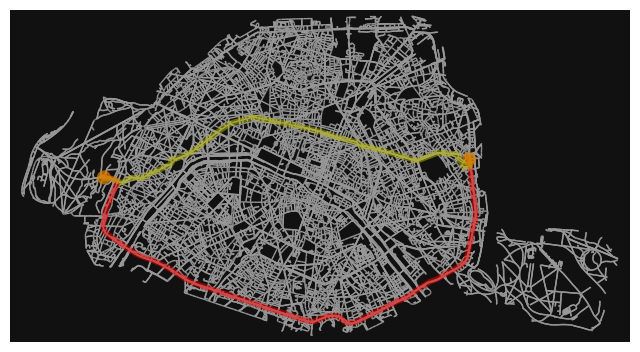

In [ ]:
n1=list(g)[0]
n2=list(g)[120]
route1=nx.shortest_path(baseline_TTD,n1,n2,weight="travel_time")
route2=nx.shortest_path(our_TTD,n1,n2,weight="travel_time")
fig, ax = ox.plot_graph_routes(
    g, routes=[route1, route2], route_colors=["r", "y"], route_linewidth=6, node_size=0
)

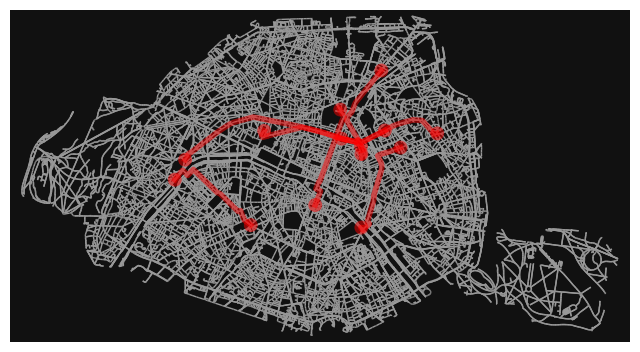

In [ ]:
fig, ax = ox.plot_graph_routes(
    g, routes=k_corridors, route_linewidth=6, node_size=0
)

In [ ]:
T=[edges_to_nodes(track) for track in T_test]

for key,clustering in clustering_dict.items():
    k_corridors,k_index,cluster_labels=clustering

    print(f'\n\n------------------\n    {key}\t\n------------------')

    print("\nk-set metrics:\n--------------")

    abs_inter=evaluate_k_metric(k_absolute_intersect,T,k_corridors)
    print("Absolute intersection: {:.4f}".format(abs_inter))

    rel_inter=evaluate_k_metric(k_relative_intersect,T,k_corridors)
    print("Relative intersection: {:.4f}".format(rel_inter))

    l_rel_inter=evaluate_k_metric(k_lenght_relative_intersect,T,k_corridors,G=g)
    print("Length intersection: {:.4f}".format(l_rel_inter))

    print("\nM metrics:\n----------")

    m_d=M_similarity(g,T,cluster_labels,k_index,ponderated=False,include_corridors=True)
    print("M average distance: {:.0f}m".format(m_d))

    ponderation_k=1000
    # m_sim=M_similarity(g,T,cluster_labels,k_index,ponderated=True,ponderation_k=ponderation_k,include_corridors=True)
    m_sim=ponderation_k/(ponderation_k+m_d)
    print("Ponderated M similarity (k={}): {:.4f}".format(ponderation_k,m_sim))

ValueError: too many values to unpack (expected 3)